# Задание. Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller



%matplotlib inline

In [2]:
airlines_passengers = pd.read_csv("../data_files/international-airline-passengers.csv", index_col=0, parse_dates=True)["Count"]
female_births = pd.read_csv("../data_files/daily-total-female-births-in-cal.csv", index_col=0, parse_dates=True)["Count"]

data = [airlines_passengers, female_births]

all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers,
    "Daily total female births in California": female_births
}

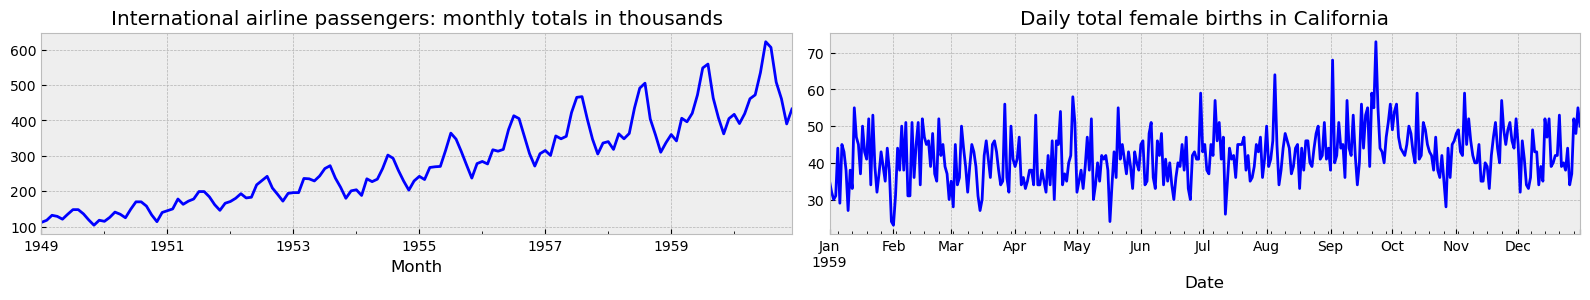

In [3]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [5]:
for key, value in all_series.items():
    print(key)
    test_stationarity(value)
    # tsplot(value)
    print("\n")

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Daily total female births in California
Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64




Первый график продаж авиакомпании не стационарный, тренд и сезонность присутствуют, а вот график по рождаемости стационарный

In [17]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)



In [18]:


# Подготовка данных для оптимизации
train_size = int(len(female_births) * 0.8)
train = female_births[:train_size]
test = female_births[train_size:]

# Функция для вычисления простого экспоненциального сглаживания
def simple_exponential_smoothing(series, alpha):
    """Простое экспоненциальное сглаживание"""
    result = [series.iloc[0]]  # Первое значение
    for i in range(1, len(series)):
        smoothed_value = alpha * series.iloc[i-1] + (1 - alpha) * result[i-1]
        result.append(smoothed_value)
    return result


from sklearn.metrics import mean_squared_error
# Функция MSE для оптимизации (принимает только один параметр alpha)
def mse_objective(params):
    alpha = params[0]  # Извлекаем alpha из массива
    
    # Получаем сглаженные значения на обучающей выборке
    smoothed_train = simple_exponential_smoothing(train, alpha)
    
    # Прогноз = последнее сглаженное значение
    forecast_value = smoothed_train[-1]
    
    # Создаем прогноз для тестовой выборки (все значения одинаковые)
    predictions = [forecast_value] * len(test)
    
    # Вычисляем MSE
    error = mean_squared_error(test, predictions)
    return error

print("Функции для оптимизации α подготовлены!")

Функции для оптимизации α подготовлены!


In [19]:
from scipy.optimize import minimize

# Запуск оптимизации для поиска оптимального α
print("Запуск оптимизации...")

# Начальное значение α
initial_alpha = [0.5]

# Оптимизация (ищем только один параметр α в диапазоне от 0 до 1)
opt = minimize(
    mse_objective, 
    x0=initial_alpha, 
    method="L-BFGS-B", 
    bounds=[(0.001, 0.999)]  # α должно быть больше 0 и меньше 1
)

print("Результаты оптимизации:")
print(f"Оптимальное значение α: {opt.x[0]:.4f}")
print(f"Минимальное значение MSE: {opt.fun:.4f}")
print(f"Успешная оптимизация: {opt.success}")
print(f"Сообщение: {opt.message}")

# Сохраняем оптимальное значение
optimal_alpha = opt.x[0]

Запуск оптимизации...
Результаты оптимизации:
Оптимальное значение α: 0.9990
Минимальное значение MSE: 45.1665
Успешная оптимизация: True
Сообщение: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


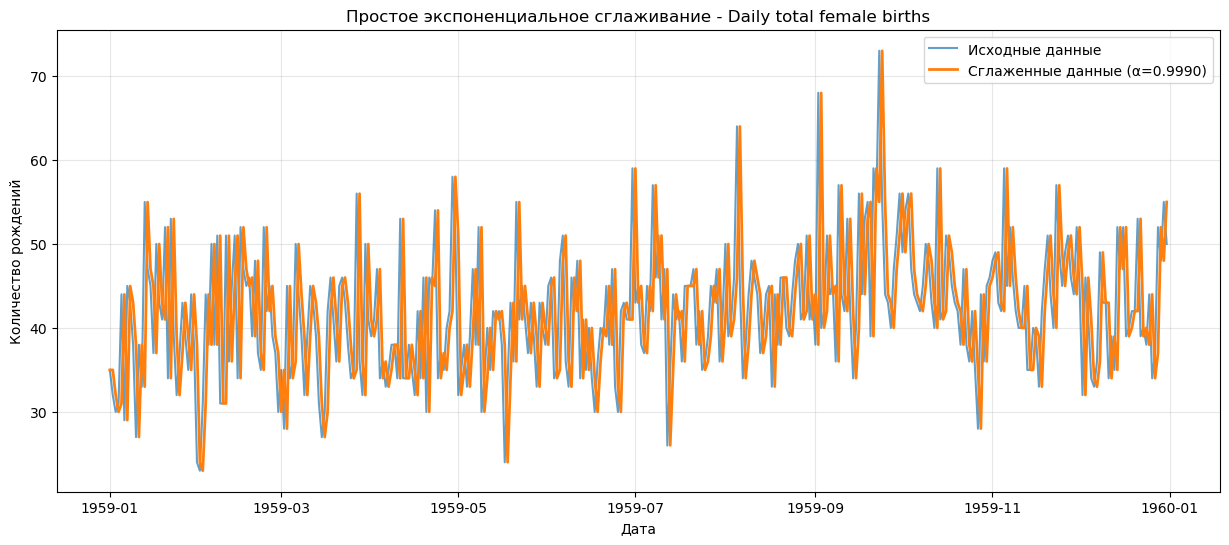

In [12]:
# Визуализация простого экспоненциального сглаживания
plt.figure(figsize=(15, 6))
plt.plot(female_births.index, female_births, label='Исходные данные', alpha=0.7)

# Получаем сглаженные значения с оптимальным alpha
smoothed_values = simple_exponential_smoothing(female_births, optimal_alpha)
plt.plot(female_births.index, smoothed_values, 
         label=f'Сглаженные данные (α={optimal_alpha:.4f})', linewidth=2)

# Создаем индекс для прогноза
last_date = female_births.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

plt.title('Простое экспоненциальное сглаживание - Daily total female births')
plt.xlabel('Дата')
plt.ylabel('Количество рождений')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [32]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    """
    Исправленная версия тройного экспоненциального сглаживания (Holt-Winters)
    """
    result = []
    seasonals = initial_seasonal_components(series, slen)
    
    # Инициализация
    smooth = series[0]
    trend = initial_trend(series, slen)
    
    for i in range(len(series)+n_preds):
        if i == 0: # начальные значения
            result.append(series[0])
            continue
            
        if i >= len(series): # прогнозирование
            m = i - len(series) + 1
            forecast = smooth + m * trend + seasonals[i % slen]
            result.append(forecast)
        else:
            val = series[i]
            # Обновляем компоненты в правильном порядке
            last_smooth = smooth
            smooth = alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            seasonals[i % slen] = gamma * (val - smooth - trend) + (1 - gamma) * seasonals[i % slen]
            
            # Добавляем сглаженное значение (не прогноз на следующий период)
            result.append(smooth + trend + seasonals[i % slen])
            
    return result


def plot_tema(alpha, beta, gamma, ser=airlines_passengers, ser_to_plot=airlines_passengers, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(15, 8))
        
        # Исходные данные
        plt.plot(range(len(ser_to_plot)), ser_to_plot, color='blue', linewidth=2, label='Исходные данные', alpha=0.8)
        
        # Сглаженные данные (только для обучающей части)
        plt.plot(range(len(ser)), tema[:len(ser)], color='red', linewidth=3, label='TEMA сглаживание')
        
        # Прогноз
        if n_preds > 0:
            forecast_start = len(ser)
            forecast_range = range(forecast_start, forecast_start + n_preds)
            plt.plot(forecast_range, tema[len(ser):], color='green', linewidth=3, 
                    linestyle='--', label=f'Прогноз ({n_preds} точек)')
        
        plt.title(f"Тройное экспоненциальное сглаживание\nα={alpha:.4f}, β={beta:.4f}, γ={gamma:.4f}")
        plt.xlabel('Период')
        plt.ylabel('Значение')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

In [33]:
series = airlines_passengers
# Увеличиваем размер обучающей выборки для лучшего обучения сезонности
train, test, val = series[:120], series[120:130], series[130:]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

# Изменяем начальные значения и добавляем более строгие ограничения
opt = minimize(mse, x0=[0.3, 0.1, 0.1], method="L-BFGS-B", 
               bounds = ((0.01, 0.99), (0.001, 0.3), (0.001, 0.99)))

In [34]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 259.0637063768575
        x: [ 1.000e-02  2.629e-01  6.313e-01]
      nit: 18
      jac: [ 2.621e+03  9.322e-04  5.684e-04]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


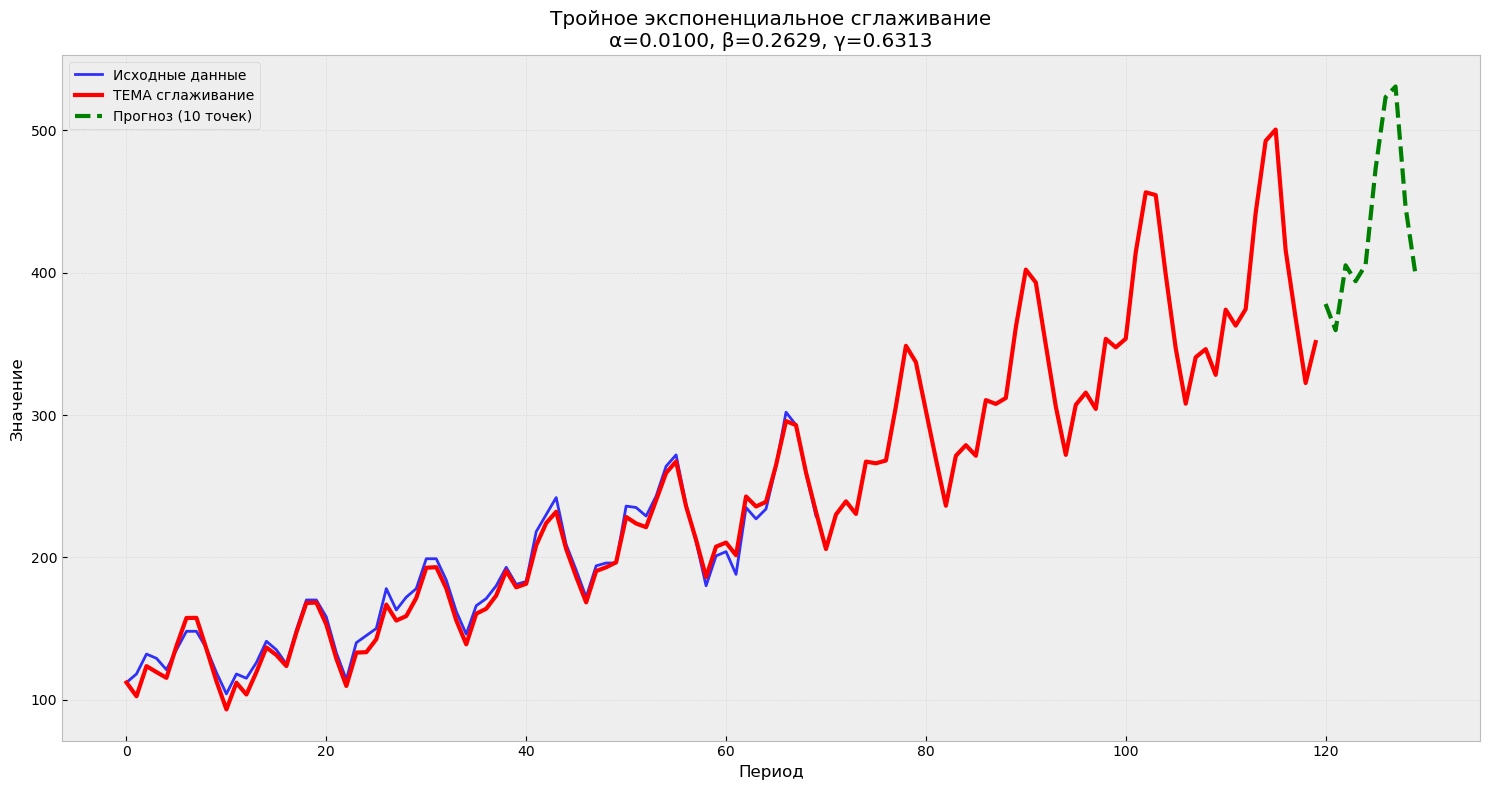

In [35]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))